# Autoencoders

We import the usual stuff and we've got one more of our own modules to import.

In [1]:
import logging
logging.disable(logging.WARNING)

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/germangoldszmidt/mambaforge/lib/python3

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

## Data
We use the `fashion_mnist` dataset.
We can take advantage of the stuff that we did in 05datasets 
and the huggingface stuff to load it.
We never actually built any models with it so let's first of all do that.

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

We convert each image into a tensor and that's going to be an `@inPlace` transform 

In [4]:
@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

We can call data set dictionary `with_transform`

In [5]:
bs = 256
tds = dsd.with_transform(transformi)

and here we have our example of a sneaker.

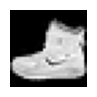

In [6]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [7]:
cf = collate_dict(ds)

We will create a collation function.
we're collating the dictionary for that dataset 
(from datasets notebook).
Let's actually make our `collate_` function something that does
`to_device` (earlier notebook) 

In [8]:
def collate_(b): return to_device(cf(b))

and we'll get a little data loaders 
function here which is going to go through each item in the dataset dictionary
and create a data loader for it and give us a dictionary of data loaders.

In [9]:
def data_loaders(dsd, bs, **kwargs): 
    return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [10]:
dls = data_loaders(tds, bs, num_workers=4, collate_fn=collate_)

dataloader of a training and a dataloader for validation, 
so we can grab the X and Y batch by just calling next on that iterator.

In [11]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

We can get the names of the features
and so we can then get create an itemgetter for our y's and we can so we'll call
that the label getter we can apply that to our labels to get the titles of
everything in our mini batch and we can then call our show images
that we created with that minibatch with those titles 
and here we have our fashion mnist minibatch.

In [12]:
labels = ds.features[y].names
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [13]:
lbl_getter = itemgetter(*yb[:16])
titles = lbl_getter(labels)
titles[:8]

('Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover')

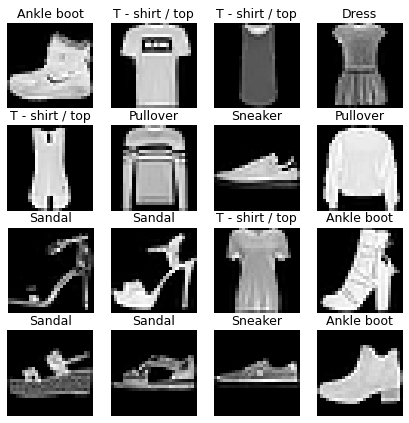

In [14]:
mpl.rcParams['figure.dpi'] = 75
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

Lets create a classifier using the code from previous notebooks.

In [15]:
from torch import optim

bs = 256
lr = 0.4

Let's create a classifier and using exactly the same code 
copy and paste it from the previous notebook.
Here is our sequential model and we are going to grab the parameters of the CNN
and the CNN I've actually moved it over to the default device.

In [16]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [17]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.7574230436325073 0.7349
1 0.6140532290935516 0.7813
2 0.48951432225704195 0.8266
3 0.4551405289888382 0.8371
4 0.42945670154094695 0.846


it's fitting very slowly. why?
Let's  go all the way back to the data set dictionary 
before it gets transformed data set dictionary 
and let's grab the training part of that
and let's grab one item.

In [18]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

We can see here the problem: for mnist we had all of the data loaded into
memory into a single big tensor.
But this huggingface one is created so that each image is a totally separate PNG image.
It is not all pre-converted into a single thing, 
and hence the data loader is spending all of its time decoding the pngs.
With htop while training we see that a single CPU is 100 used.  

## Autoencoder

In [19]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [20]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss,count = 0.,0
        for xb,_ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred,xb).item()*n
    print(epoch, f'{tot_loss/count:.3f}')

In [21]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,_ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch)

In [22]:
ae = nn.Sequential(   #28x28
    nn.ZeroPad2d(2),  #32x32
    conv(1,2),        #16x16
    conv(2,4),        #8x8
#     conv(4,8),        #4x4
#     deconv(8,4),      #8x8
    deconv(4,2),      #16x16
    deconv(2,1, act=False), #32x32
    nn.ZeroPad2d(-2), #28x28
    nn.Sigmoid()
).to(def_device)

In [23]:
eval(ae, F.mse_loss, dv)

0 0.182


In [24]:
opt = optim.AdamW(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.016
1 0.014
2 0.014
3 0.013
4 0.013


In [25]:
opt = optim.AdamW(ae.parameters(), lr=0.01)
fit(5, ae, F.l1_loss, opt, dt, dv)

0 0.062
1 0.060
2 0.059
3 0.058
4 0.058


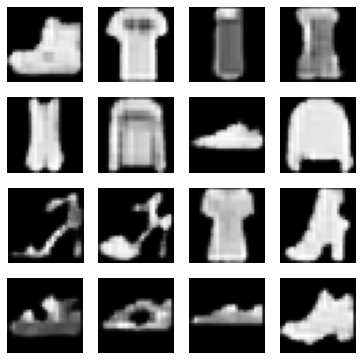

In [26]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

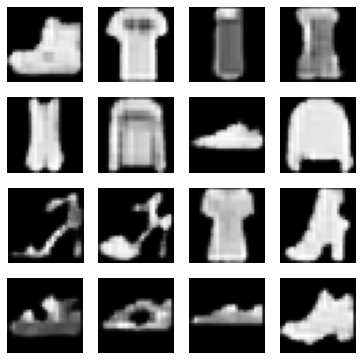

In [27]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

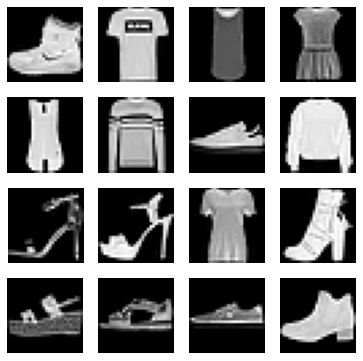

In [28]:
show_images(xb[:16].data.cpu(), imsize=1.5)